In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn import linear_model, datasets

# Analysis

In [2]:
# données simulées du TME2
X1, Y1 = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1)
X2, Y2 = make_blobs(n_samples=200, n_features=2, centers=3)
X3, Y3 = make_moons(n_samples=200, shuffle=True, noise=None, random_state=None)

Xs = [X1,X2,X3]
Ys = [Y1,Y2,Y3]

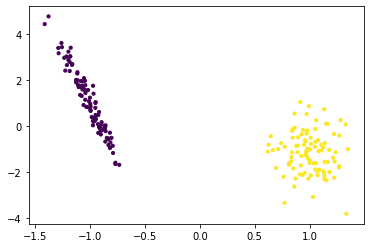

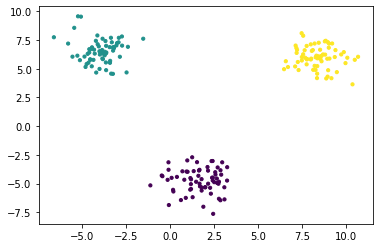

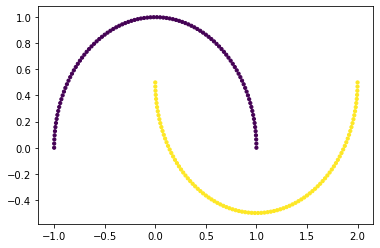

In [3]:
#show datasets
for X, Y in zip(Xs,Ys):
    plt.scatter(X[:, 0], X[:, 1], s=10, c=Y)
    plt.show()

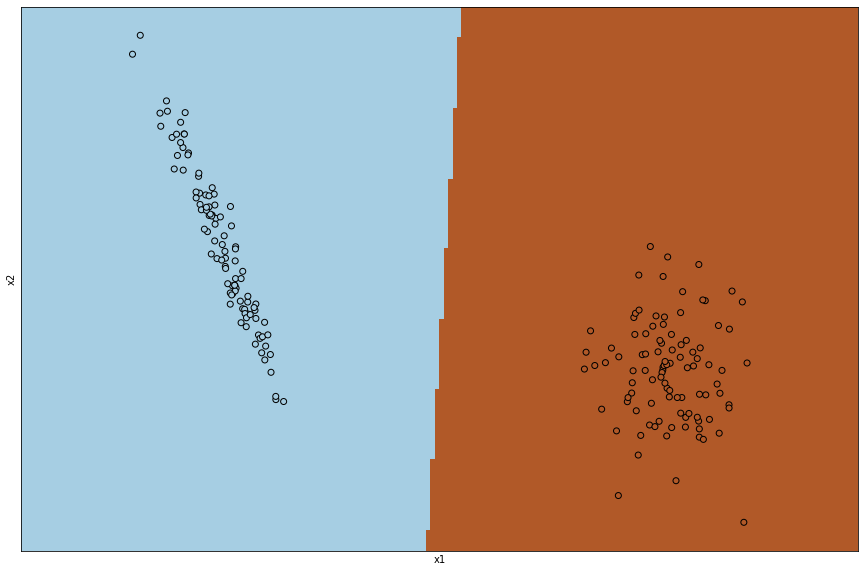

/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


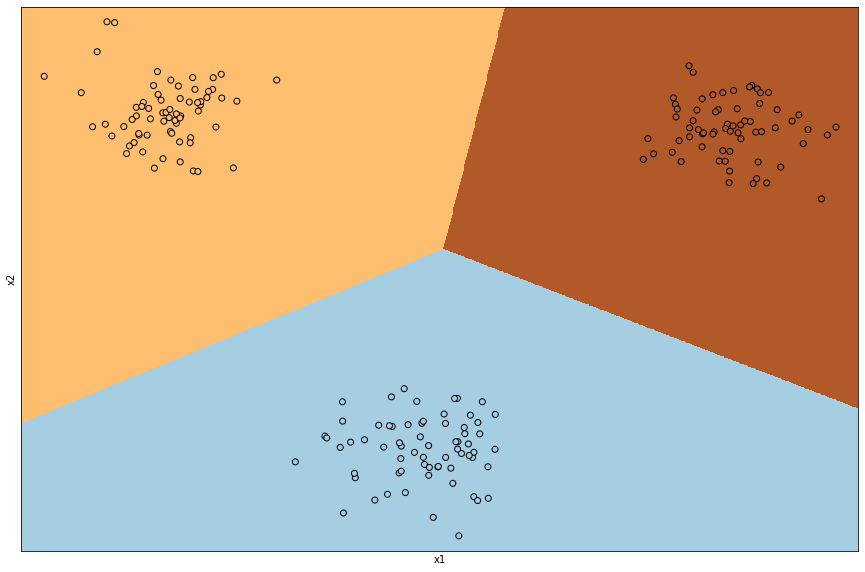

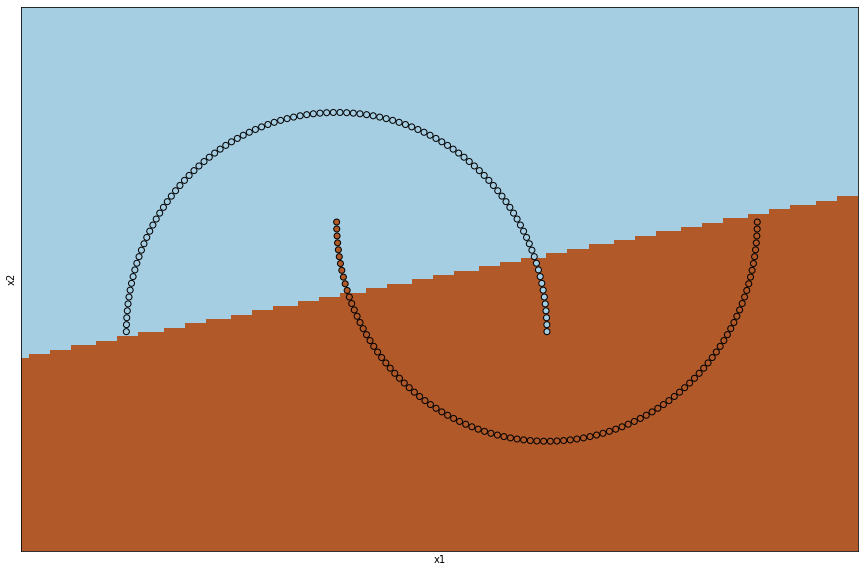

In [4]:
# boundaries on learning set
logreg = linear_model.LogisticRegression(C=1e5, solver='lbfgs')

for X, Y in zip(Xs,Ys):
    logreg.fit(X, Y)
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
    
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(15, 10))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
    
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()
    
    

In [5]:
def split_data(data, k):
    chunks = [None]*k
    c_size = int(len(data) / k)
    for i in range(k):
        chunks[i] = data[i*c_size:(i+1)*c_size]
    return chunks

def cross_validation(X,Y, k, method):
    data = list(zip(X,Y))
    chunks = split_data(data,k)
    scores = []
    for i in range(len(chunks)):
        test_data = chunks[i].copy()
        test_X, test_y = zip(*test_data)

        train_chunks = [chunks[c].copy() for c in range(len(chunks)) if(c != i)]
        train_data = []
        for tc in train_chunks:
            train_data.extend(tc)
            
        train_X, train_y = zip(*train_data)

        method.fit(train_X, train_y)
        prediction = method.predict(test_X)

        score = sum( [1 if(y == y_est) else 0 for y,y_est in zip(test_y, prediction)] ) / len(test_y)
        scores.append(score)
    
    return np.mean(scores) 



In [6]:
# k-fold precision
logreg = linear_model.LogisticRegression(C=1e5, solver='lbfgs')

for X, Y, name in zip(Xs,Ys, ["linear", "blobs", 'moons']):
    print(name + ": " + str(cross_validation(X,Y,5,logreg)) )
    

linear: 1.0
blobs: 1.0
moons: 0.885


/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/py

# Custom logistic regression

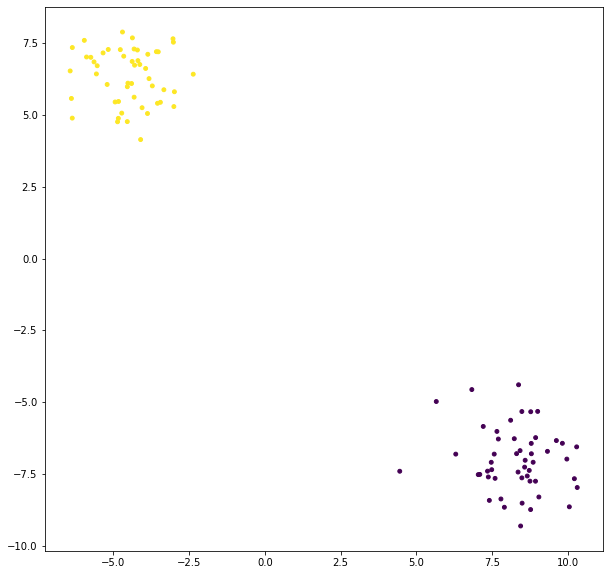

In [7]:
X, Y = make_blobs(n_samples=100, n_features=2, centers=2)
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], s=15, c=Y)
plt.show()

In [8]:
def log_likelihood(X,Y,theta):
    weighted_feat = theta.dot(X.T)
    return -sum( Y*weighted_feat - np.log(1 + np.exp(weighted_feat)) )

def prob_0(x,theta):
    return 1/(1+np.exp(theta.dot(x)))

def prob_1(x,theta):
    return np.exp(theta.dot(x)) /(1+np.exp(theta.dot(x)))
    
def predict(X,theta):    
    X = np.array(X)
    
    y_est = []
    for x in X:
        scores = np.array([prob_0(x,theta),prob_1(x,theta)])
        y_est.append(np.argmax(scores))
    return np.array(y_est)

def gradient_1(X,Y,theta):
    y_est = prob_1(X.T,theta) # p(y=1|x)
    grad = []
    for x, y, y_hat in zip(X,Y,y_est):
        grad.append(x*(y-y_hat))
    return -sum(grad) # 1 x p
    
def gradient_2(X,Y,theta):
    y_est = prob_1(X.T,theta) # p(y=1|x)
    grad = []
    for x, y_hat in zip(X,y_est):
        mat = np.zeros((len(x),len(x)))
        for i in range(len(x)):
            for j in range(len(x)):
                mat[i,j] = x[i] * x.T[j]
        
        grad.append(mat*y_hat*(1-y_hat))
    return sum(np.array(grad)) # p x p

In [9]:
theta = np.zeros(np.size(X,1))

print(log_likelihood(X,Y,theta))
print(predict(X,theta))

print(gradient_1(X,Y, theta))
print(gradient_2(X,Y, theta))

69.31471805599459
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 319.85290222 -333.25162969]
[[ 1140.69163696 -1084.78585506]
 [-1084.78585506  1139.32328936]]


In [10]:
from numpy.linalg import LinAlgError

def gradient_descent(X,Y, alph=0.1, max_iter=1000):
    theta = np.zeros(np.size(X,1)) #X -> tuple ??? 
    X = np.array(X)
    ll = log_likelihood(X,Y,theta)
    for t in range(max_iter):
        grad_2 = gradient_2(X,Y, theta)
        grad_1 = gradient_1(X,Y, theta)
        try:
            theta = theta - alph * np.linalg.inv(grad_2).dot(grad_1)
        except LinAlgError: #add small noise
            grad_2 = grad_2+1e-10*np.random.rand(grad_2.shape[0], grad_2.shape[1])
            theta = theta - alph * np.linalg.inv(grad_2).dot(grad_1)
        n_ll = log_likelihood(X,Y,theta)
        #print(theta, n_ll)
        
    return theta
        
#theta = gradient_descent(X,Y)
#predict(X,theta)

In [11]:
def c_cross_validation(X,Y, k):
    data = list(zip(X,Y))
    chunks = split_data(data,k)
    scores = []
    for i in range(len(chunks)):
        test_data = chunks[i].copy()
        test_X, test_y = zip(*test_data)

        train_chunks = [chunks[c].copy() for c in range(len(chunks)) if(c != i)]
        train_data = []
        for tc in train_chunks:
            train_data.extend(tc)
            
        train_X, train_y = zip(*train_data)

        theta = gradient_descent(train_X, train_y)
        prediction = predict(test_X, theta)

        score = sum( [1 if(y == y_est) else 0 for y,y_est in zip(test_y, prediction)] ) / len(test_y)
        scores.append(score)
    
    return np.mean(scores) 

In [12]:
# k-fold precision
# test on same sets of data

#Custom
for X, Y, name in zip(Xs,Ys, ["linear", "blobs", 'moons']):
    print(name + ": " + str( c_cross_validation(X ,Y, 10)) )
    

linear: 1.0


/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


blobs: 0.335
moons: 0.8699999999999999


In [13]:
#sklearn
logreg = linear_model.LogisticRegression(C=1e5, solver='lbfgs')

for X, Y, name in zip(Xs,Ys, ["linear", "blobs", 'moons']):
    print(name + ": " + str(cross_validation(X,Y,10,logreg)) )
    

linear: 1.0
blobs: 1.0
moons: 0.8899999999999999


/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/.local/lib/py

Vastly dissimilar results for blobs.  
And a tad lower for moons.  
Also custom version slow. 

## Import clinical datasets

In [14]:
df_cancer = pd.read_csv("data/breast-cancer-wisconsin.data", names=["IDs", "Clump Thickness", 
                                                                    "Uniformity of Cell Size", 
                                                                    "Uniformity of Cell Shape", 
                                                                    "Marginal Adhesion", 
                                                                    "Single Epithelial Cell Size", 
                                                                    "Bare Nuclei", 
                                                                    "Bland Chromatin", 
                                                                    "Normal Nucleoli", 
                                                                    "Mitoses",
                                                                    "Class"
                                                                   ])

df_cancer.set_index('IDs', inplace = True)
df_cancer["Bare Nuclei"] = pd.to_numeric(df_cancer["Bare Nuclei"],errors='coerce')
df_cancer.fillna( df_cancer.median() , inplace = True)
df_cancer["Bare Nuclei"] = df_cancer["Bare Nuclei"].astype(np.int64)

print(df_cancer.dtypes)
df_cancer

Clump Thickness                int64
Uniformity of Cell Size        int64
Uniformity of Cell Shape       int64
Marginal Adhesion              int64
Single Epithelial Cell Size    int64
Bare Nuclei                    int64
Bland Chromatin                int64
Normal Nucleoli                int64
Mitoses                        int64
Class                          int64
dtype: object


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
IDs,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
776715,3,1,1,1,3,2,1,1,1,2
841769,2,1,1,1,2,1,1,1,1,2
888820,5,10,10,3,7,3,8,10,2,4


In [15]:
cancer_class = df_cancer["Class"]
df_cancer.drop(columns="Class", inplace=True)


print(cancer_class)
df_cancer.head()

IDs
1000025    2
1002945    2
1015425    2
1016277    2
1017023    2
          ..
776715     2
841769     2
888820     4
897471     4
897471     4
Name: Class, Length: 699, dtype: int64


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
IDs,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1
1002945,5,4,4,5,7,10,3,2,1
1015425,3,1,1,1,2,2,3,1,1
1016277,6,8,8,1,3,4,3,7,1
1017023,4,1,1,3,2,1,3,1,1


In [16]:
df_mice = pd.read_excel("data/Data_Cortex_Nuclear.xls")
df_mice.fillna( df_mice.median() , inplace = True)
df_mice.set_index("MouseID", inplace =  True)

to_quantify = ['Genotype', 'Treatment', 'Behavior']
for c in to_quantify:
    dumbed_up = pd.get_dummies(df_mice[c]) 
    df_mice.drop(columns = c, inplace = True)
    df_mice = df_mice.join(dumbed_up)

df_mice.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,EGR1_N,H3MeK4_N,CaNA_N,class,Control,Ts65Dn,Memantine,Saline,C/S,S/C
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.131790,0.128186,1.675652,c-CS-m,1,0,1,0,1,0
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.135103,0.131119,1.743610,c-CS-m,1,0,1,0,1,0
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.133362,0.127431,1.926427,c-CS-m,1,0,1,0,1,0
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.147444,0.146901,1.700563,c-CS-m,1,0,1,0,1,0
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.140314,0.148380,1.839730,c-CS-m,1,0,1,0,1,0


In [17]:
df_mice["class"] = df_mice["class"] == "t-SC-s"         #binaire
mice_class = df_mice["class"]
df_mice.drop(columns="class", inplace=True)

print(mice_class)
df_mice.head()

MouseID
309_1       False
309_2       False
309_3       False
309_4       False
309_5       False
            ...  
J3295_11     True
J3295_12     True
J3295_13     True
J3295_14     True
J3295_15     True
Name: class, Length: 1080, dtype: bool


,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Control,Ts65Dn,Memantine,Saline,C/S,S/C
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.114783,0.131790,0.128186,1.675652,1,0,1,0,1,0
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.111974,0.135103,0.131119,1.743610,1,0,1,0,1,0
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.111883,0.133362,0.127431,1.926427,1,0,1,0,1,0
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.130405,0.147444,0.146901,1.700563,1,0,1,0,1,0
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.118481,0.140314,0.148380,1.839730,1,0,1,0,1,0


### Cancer Data

In [18]:
Xx = [df_cancer.to_numpy(), df_mice.to_numpy()]
Yy = [cancer_class, mice_class]


#sklearn
logreg = linear_model.LogisticRegression(C=1e5, solver='lbfgs')

for X, Y, name in zip(Xx,Yy, ["cancer", "mice"]):
    print(name + ": " + str(cross_validation(X,Y,10,logreg)) )
    

cancer: 0.9637681159420289
mice: 0.9777777777777776


In [19]:
#Custom

np.seterr(divide='ignore', invalid='ignore', over='print')

for X, Y, name in zip(Xx, Yy, ["cancer", "mice"]):
    print(name + ": " + str( c_cross_validation(X ,Y, 10)) )
    

cancer: 0.0
mice: 0.875


The sklearn method is very very good for these 2 datasets, above 95% precision  

The custom method have lower precision.  
And 0 on the cancer dataset (due to overflow in exponential function).  

As said before, the custom method is extremely slow, it took all night to return as compared to few seconds with sklearn.  
Computing the hessian matrix is computationnally heavy, especially for decent to large datasets such as these.  

Since logistic regression converges, we can suggest the custom method took all 1000 iterations (so did not converge), we might have a result closer to sklearn's with more iterations, but would take even longer to return a value. 